In [99]:
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

In [100]:
df = pd.read_csv(r'C:\Users\supra\Downloads\Updated_XYZ_Sportswear_Orders_Dataset.csv')

In [101]:
df.head()

,Order Date,Requested Delivery Date,Customer Country Code,Product Code,Description,Order Type,Customer Order Code,Value,Currency,Items,Route,Value per Item
0,01.01.2009,18.02.2009,DE,PK003,Economy Parka,VO,COD00001,269.87,EUR,8,East,33.733750
1,01.01.2009,10.02.2009,FR,PK001,Advanced Parka,VO,COD00002,170.34,EUR,2,West,85.170000
2,01.01.2009,17.01.2009,ES,PK002,Premium Parka,VO,COD00003,61.09,EUR,7,West,8.727143
3,03.01.2009,28.01.2009,IT,PK003,Economy Parka,VO,COD00004,251.18,EUR,6,North,41.863333
4,03.01.2009,18.01.2009,DE,PK004,Basic Parka,VO,COD00005,153.33,EUR,5,West,30.666000


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2421 entries, 0 to 2420
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Order Date               2421 non-null   object 
 1   Requested Delivery Date  2421 non-null   object 
 2   Customer Country Code    2421 non-null   object 
 3   Product Code             2421 non-null   object 
 4   Description              2421 non-null   object 
 5   Order Type               2421 non-null   object 
 6   Customer Order Code      2421 non-null   object 
 7   Value                    2421 non-null   float64
 8   Currency                 2421 non-null   object 
 9   Items                    2421 non-null   int64  
 10  Route                    2421 non-null   object 
 11  Value per Item           2421 non-null   float64
dtypes: float64(2), int64(1), object(9)
memory usage: 227.1+ KB


In [103]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d.%m.%Y')
df['Requested Delivery Date'] = pd.to_datetime(df['Requested Delivery Date'], format='%d.%m.%Y')

In [104]:
from datetime import date
df.sort_values(by='Order Date', inplace=True)

In [105]:
df.head()

,Order Date,Requested Delivery Date,Customer Country Code,Product Code,Description,Order Type,Customer Order Code,Value,Currency,Items,Route,Value per Item
0,2009-01-01,2009-02-18,DE,PK003,Economy Parka,VO,COD00001,269.87,EUR,8,East,33.733750
1,2009-01-01,2009-02-10,FR,PK001,Advanced Parka,VO,COD00002,170.34,EUR,2,West,85.170000
2,2009-01-01,2009-01-17,ES,PK002,Premium Parka,VO,COD00003,61.09,EUR,7,West,8.727143
3,2009-01-03,2009-01-28,IT,PK003,Economy Parka,VO,COD00004,251.18,EUR,6,North,41.863333
4,2009-01-03,2009-01-18,DE,PK004,Basic Parka,VO,COD00005,153.33,EUR,5,West,30.666000


In [106]:
nan_values = df.isna().sum()
print("NaN values per column:")
print(nan_values)

NaN values per column:
Order Date                 0
Requested Delivery Date    0
Customer Country Code      0
Product Code               0
Description                0
Order Type                 0
Customer Order Code        0
Value                      0
Currency                   0
Items                      0
Route                      0
Value per Item             0
dtype: int64


In [107]:
df.drop_duplicates(inplace=True)

In [108]:
def month_to_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    else:
        return 'Winter'

df['Delivery Month'] = df['Requested Delivery Date'].dt.month
df['Season'] = df['Delivery Month'].apply(month_to_season)

df['Lead Time'] = (df['Requested Delivery Date'] - df['Order Date']).dt.days

df['advanced_order'] = (df['Lead Time'] >= 30).astype(int)

df['Value/Item'] = df['Value']/df['Items']

df['Season_Num'] = df['Season'].map({'Winter': 1, 'Spring': 2, 'Summer': 3, 'Fall': 4})

# df['Customer ID'] = 

In [109]:
df['Previous Month'] = df['Order Date'].dt.to_period('M') - 1

# Initialize the 'Estimated Price' column with zeros
df['Estimated Price'] = 0.0

# Iterate through each row to calculate the estimated price
for index, row in df.iterrows():
    previous_month_price = df.loc[
        (df['Product Code'] == row['Product Code']) & (df['Previous Month'] == row['Order Date'].to_period('M')),
        'Value/Item'
    ].mean()

    # Update 'Estimated Price' with the calculated value
    df.at[index, 'Estimated Price'] = previous_month_price if not pd.isnull(previous_month_price) else 0.0

# Drop the 'Previous Month' column if no longer needed
df = df.drop(columns=['Previous Month'])

In [110]:
df['Order Month'] = df['Order Date'].dt.to_period('M')
df['Estimated price next month'] = df.groupby(['Product Code', 'Order Month'])['Value'].transform('mean')
df['Estimated price next month'] = df.groupby(['Product Code'])['Estimated price next month'].shift(1)
df.loc[df['Order Month'] == '2009-01-01', 'Estimated price next month'] = 0.0


In [111]:
df[['Estimated price next month', 'Order Date', 'Product Code', 'Value per Item']].head(70)


,Estimated price next month,Order Date,Product Code,Value per Item
0,0.000000,2009-01-01,PK003,33.733750
1,0.000000,2009-01-01,PK001,85.170000
2,0.000000,2009-01-01,PK002,8.727143
3,0.000000,2009-01-03,PK003,41.863333
4,0.000000,2009-01-03,PK004,30.666000
...,...,...,...,...
65,180.720769,2009-02-03,PK004,64.075000
66,177.080667,2009-02-04,PK003,31.185556
67,180.720769,2009-02-05,PK004,18.692500
68,180.720769,2009-02-05,PK004,242.170000


EDA

1.

In [112]:
grouped_data = df.groupby(['Customer Country Code', 'Season'])['Items'].sum().reset_index()

In [113]:
# Find the country with the highest number of items in each season
max_items = grouped_data.loc[grouped_data.groupby('Season')['Items'].idxmax()]

# Find the country with the lowest number of items in each season
min_items = grouped_data.loc[grouped_data.groupby('Season')['Items'].idxmin()]

# Display the results
print("Countries with the highest number of items in each season:")
print(max_items)

print("\nCountries with the lowest number of items in each season:")
print(min_items)

Countries with the highest number of items in each season:
   Customer Country Code  Season  Items
8                     FR    Fall   1014
1                     DE  Spring    552
10                    FR  Summer    571
3                     DE  Winter   1216

Countries with the lowest number of items in each season:
   Customer Country Code  Season  Items
0                     DE    Fall    682
5                     ES  Spring    435
18                    IT  Summer    385
23                    RU  Winter    860


2.

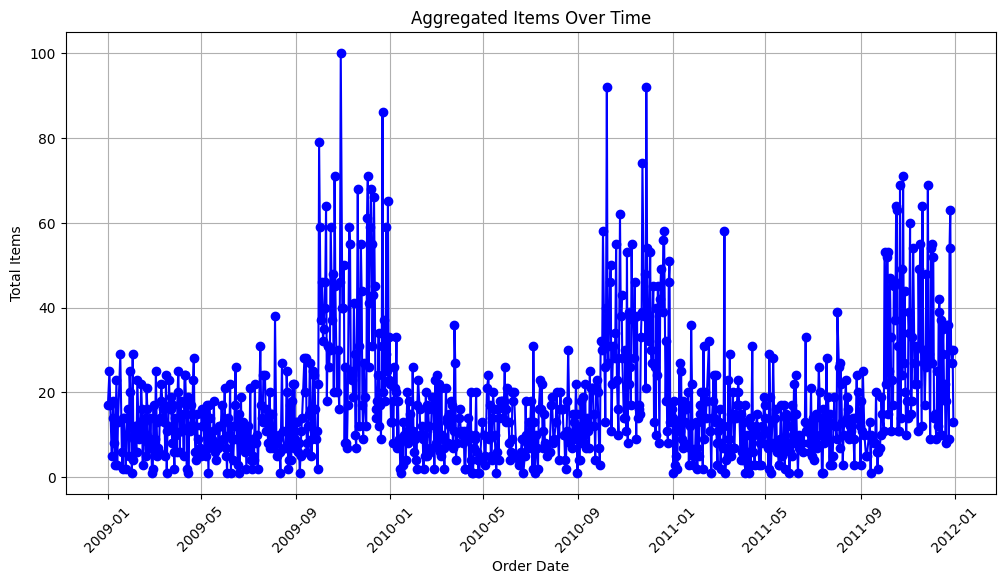

In [114]:
agg_df = df.groupby('Order Date')['Items'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(agg_df['Order Date'], agg_df['Items'], marker='o', linestyle='-', color='b')
plt.title('Aggregated Items Over Time')
plt.xlabel('Order Date')
plt.ylabel('Total Items')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

3.

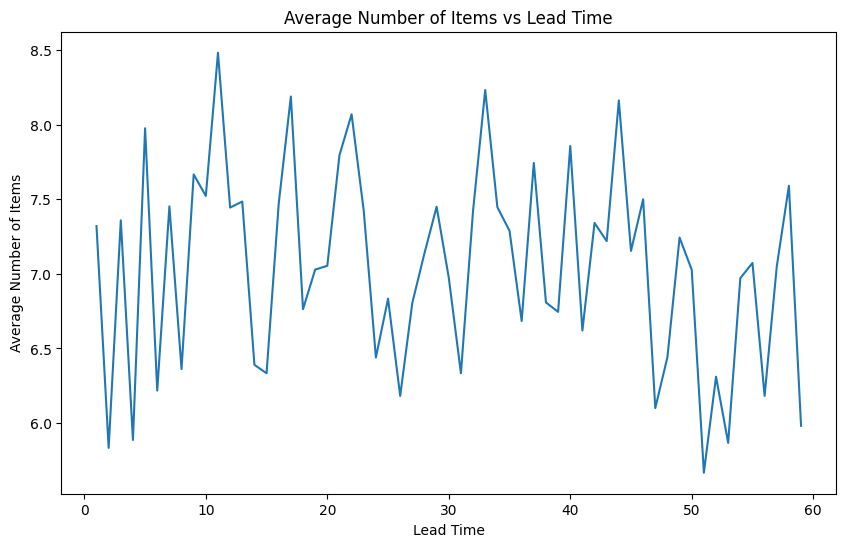

In [115]:
average_items_by_lead_time = df.groupby('Lead Time')['Items'].mean().reset_index()

# Line plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='Lead Time', y='Items', data=average_items_by_lead_time)

# Set plot title and labels
plt.title('Average Number of Items vs Lead Time')
plt.xlabel('Lead Time')
plt.ylabel('Average Number of Items')

# Show the plot
plt.show()

4.

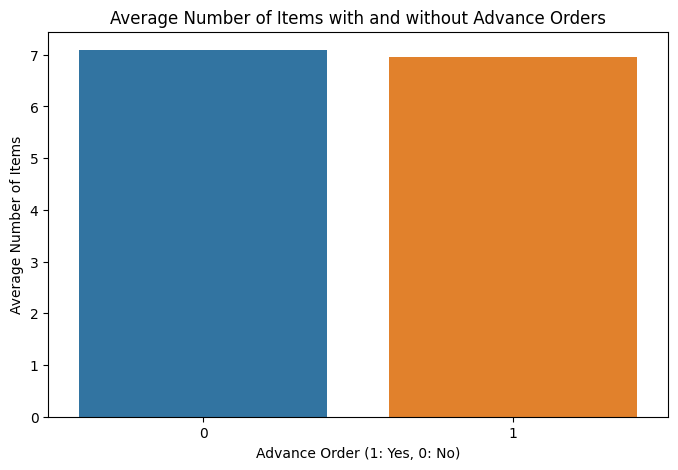

In [116]:
avg_items_by_advance_order = df.groupby('advanced_order')['Items'].mean().reset_index()

# Bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x='advanced_order', y='Items', data=avg_items_by_advance_order)

# Set plot title and labels
plt.title('Average Number of Items with and without Advance Orders')
plt.xlabel('Advance Order (1: Yes, 0: No)')
plt.ylabel('Average Number of Items')

# Show the plot
plt.show()

Choice prob

In [117]:
features = ['Order Date', 'Requested Delivery Date', 'Customer Country Code',
            'Description', 'Order Type', 'Customer Order Code',
            'Value', 'Currency', 'Items', 'Route',
            'Delivery Month', 'Season', 'Lead Time', 'advanced_order',
            'Value/Item']

X = df[features]
y = df['Product Code']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

categorical_features = ['Season', 'Customer Country Code', 'Route', 'advanced_order']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numerical_features = ['Lead Time', 'Items', 'Value', 'Value/Item']
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])



In [118]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, multi_class='multinomial'))
])

In [119]:
from sklearn.metrics import log_loss

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded)
model.fit(X_train, y_train)

y_pred_probs = model.predict_proba(X_test)

logloss = log_loss(y_test, y_pred_probs)
print(f'Log Loss: {logloss:.4f}')

Log Loss: 1.3950


In [120]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

probabilities = model.predict_proba(X)

prob_cols = [f'prob_{code}' for code in le.classes_]
df_probs = pd.DataFrame(probabilities, columns=prob_cols, index=X.index)

df_with_probs = df.join(df_probs)

seasonal_choice_probabilities = df_with_probs.groupby('Season')[prob_cols].mean()

print(seasonal_choice_probabilities)


Accuracy: 0.2206
        prob_PK001  prob_PK002  prob_PK003  prob_PK004
Season                                                
Fall      0.249862    0.261572    0.256085    0.232481
Spring    0.254884    0.255350    0.244563    0.245203
Summer    0.222808    0.260916    0.230448    0.285829
Winter    0.280340    0.223797    0.247216    0.248647


In [121]:
from sklearn.metrics import classification_report, confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)


Confusion Matrix:
[[23 34 30 35]
 [29 29 31 33]
 [26 26 21 45]
 [34 29 26 34]]

Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.19      0.20       122
           1       0.25      0.24      0.24       122
           2       0.19      0.18      0.19       118
           3       0.23      0.28      0.25       123

    accuracy                           0.22       485
   macro avg       0.22      0.22      0.22       485
weighted avg       0.22      0.22      0.22       485



TSA

Check for Stationarity

In [122]:
# Mention the null and alternate hyoo

In [123]:
items_column = "Items"

def adfuller_test(Items):
    df.sort_values(by='Order Date', inplace=True)
    result=adfuller(Items)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [124]:
df_ts = df[['Requested Delivery Date','Items']]

In [125]:
df_ts.head()

,Requested Delivery Date,Items
0,2009-02-18,8
1,2009-02-10,2
2,2009-01-17,7
3,2009-01-28,6
4,2009-01-18,5


In [126]:
df_ts.set_index('Requested Delivery Date', inplace = True)

<Axes: xlabel='Requested Delivery Date'>

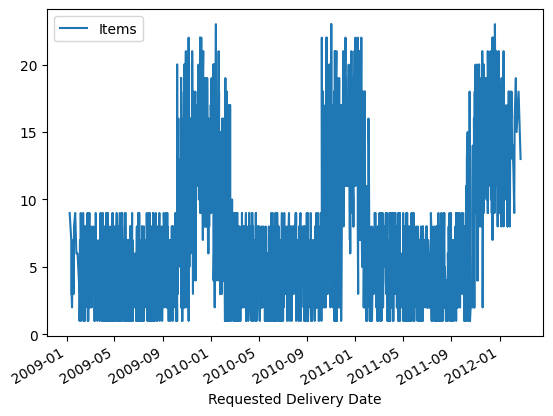

In [127]:
df_ts.plot()  # To observe the trend in the data


In [128]:
adfuller_test(df_ts['Items'])

ADF Test Statistic : -2.847368712369648
p-value : 0.05181955502912273
#Lags Used : 14
Number of Observations Used : 2406
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


#Differencing

In [129]:
df_ts['Seasonal Difference Items']=df_ts['Items']-df_ts['Items'].shift(12)

In [130]:
## Again test dickey fuller test
adfuller_test(df_ts['Seasonal Difference Items'].dropna())

ADF Test Statistic : -10.22609188531582
p-value : 5.172401135773686e-18
#Lags Used : 26
Number of Observations Used : 2382
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [131]:
df_ts.dropna(inplace=True)

<Axes: xlabel='Requested Delivery Date'>

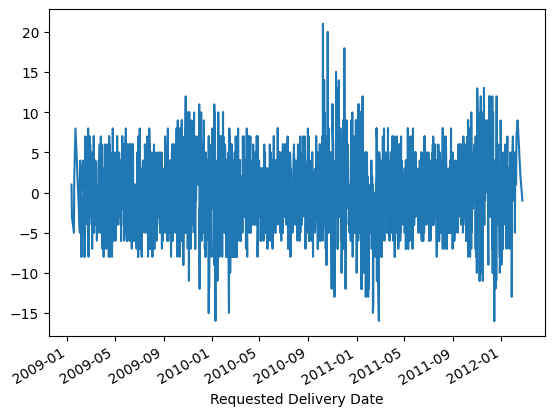

In [132]:
df_ts['Seasonal Difference Items'].plot()

Autocorrelation Model
Final Thoughts on Autocorrelation and Partial Autocorrelation

Identification of an AR model is often best done with the PACF.

For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor. Identification of an MA model is often best done with the ACF rather than the PACF.

For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model. p,d,q p AR model lags d differencing q MA lags

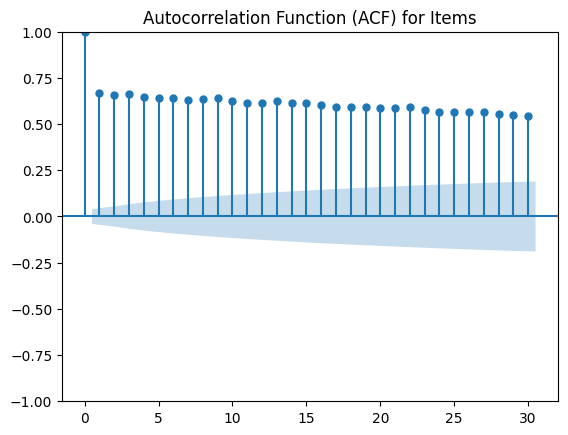

In [133]:
plot_acf(df_ts[items_column], lags=30)  # You can adjust the number of lags as needed
plt.title('Autocorrelation Function (ACF) for {}'.format(items_column))
plt.show()



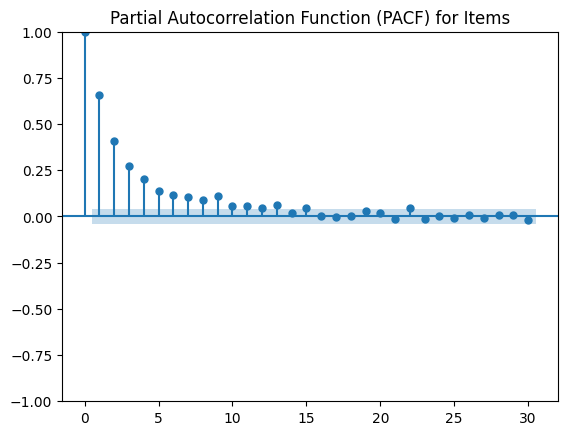

In [134]:
plot_pacf(df[items_column], lags=30)
plt.title('Partial Autocorrelation Function (PACF) for {}'.format(items_column))
plt.show()

In [135]:
df_ts.head()

,Items,Seasonal Difference Items
Requested Delivery Date,,
2009-01-18,3,-5.0
2009-03-02,7,5.0
2009-02-06,7,0.0
2009-02-04,7,1.0
2009-02-22,2,-3.0


In [136]:
df_ts.tail()

,Items,Seasonal Difference Items
Requested Delivery Date,,
2012-01-30,16,7.0
2012-01-19,11,-1.0
2012-01-10,16,1.0
2012-02-04,14,5.0
2012-02-04,13,-5.0


In [137]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df['Items'], order=(1, 1, 1))
results = model.fit()

print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Items   No. Observations:                 2421
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6171.499
Date:                Mon, 11 Dec 2023   AIC                          12348.997
Time:                        14:22:28   BIC                          12366.372
Sample:                             0   HQIC                         12355.315
                               - 2421                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0117      0.021     -0.573      0.567      -0.052       0.028
ma.L1         -0.8624      0.009    -91.661      0.000      -0.881      -0.844
sigma2         9.6019      0.275     34.936      0.0

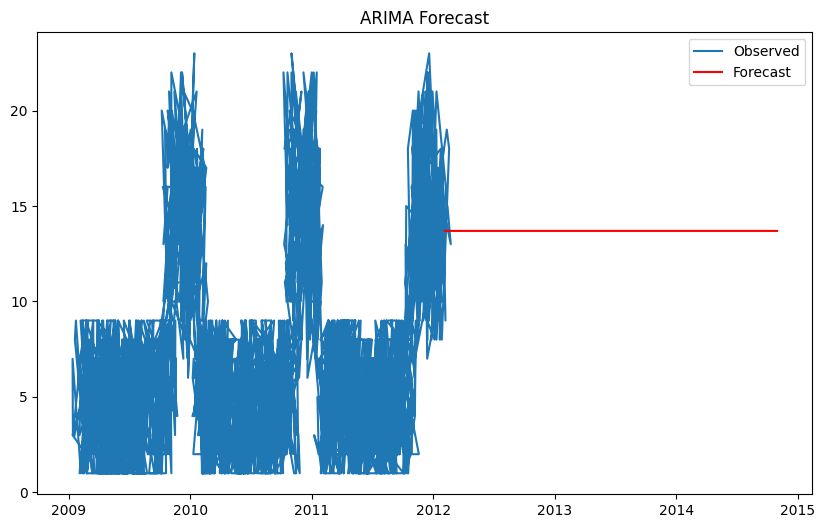

In [138]:
forecast_steps = 1000  # You can adjust the number of steps to forecast
forecast = results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(df_ts.index[-1] + pd.DateOffset(1), periods=forecast_steps, freq='D')
forecast_values = forecast.predicted_mean

# Plot the original data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(df_ts['Items'], label='Observed')
plt.plot(forecast_index, forecast_values, label='Forecast', color='red')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

In [139]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(df['Items'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results_sarima=model.fit()
results_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Items   No. Observations:                 2421
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -6174.022
Date:                            Mon, 11 Dec 2023   AIC                          12358.044
Time:                                    14:22:33   BIC                          12386.977
Sample:                                         0   HQIC                         12368.568
                                           - 2421                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0135      0.021     -0.652      0.514      -0.054       0.027
ma.L1         -0.8608      0.010    -89.773      0.000      -0.880      -0.842
ar.S.L12      -0.0066      0.019     -0.345      0.730      -0.044       0.031
ma.S.L12      -0.9867      0.006   -169.279      0.000      -0.998      -0.975
sigma2         9.6908      0.279     34.695      0.000       9.143      10.238
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 4.05
Prob(Q):                              1.00   Prob(JB):                         0.13
Heteroskedasticity (H):               1.03   Skew:                             0.07
Prob(H) (two-sided):                  0.67   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

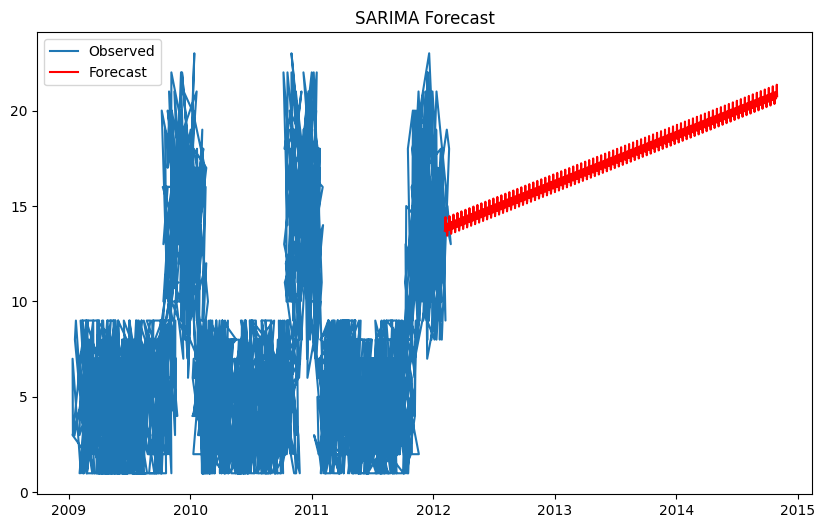

In [140]:
forecast_steps = 1000
forecast = results_sarima.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(df_ts.index[-1] + pd.DateOffset(1), periods=forecast_steps, freq='D')
forecast_values = forecast.predicted_mean

# Plot the original data and the forecast
plt.figure(figsize=(10, 6))
plt.plot(df_ts['Items'], label='Observed')
plt.plot(forecast_index, forecast_values, label='Forecast', color='red')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

In [150]:
from datetime import datetime, timedelta
import pandas as pd

# Function to predict future values for a particular season and year
def predict_future_values_seasonal(model, start_season, start_year, forecast_periods):
    # Convert the season to a month (e.g., start of the season)
    start_month = (start_season - 1) * 3 + 1

    # Create a datetime object for the specified start month and year
    start_date = datetime(start_year, start_month, 1)

    # Make forecasts
    forecast = model.get_forecast(steps=forecast_periods)

    # Extract forecasted values and confidence intervals
    forecast_values = forecast.predicted_mean
    forecast_conf_int = forecast.conf_int()

    # Create a date index for the forecasted values with quarterly start frequency
    forecast_index = pd.date_range(start=start_date, periods=forecast_periods, freq='QS')

    # Combine forecast values and confidence intervals into a DataFrame
    forecast_df = pd.DataFrame({
        'Forecast': forecast_values.values,
        'Lower CI': forecast_conf_int.iloc[:, 0].values,
        'Upper CI': forecast_conf_int.iloc[:, 1].values
    }, index=forecast_index)

    return forecast_df

test_year = 2012

forecast_periods = 4  # Assuming quarterly forecasts, adjust as needed

# Call the function to get the forecast for the specified season and year
forecast_summer = predict_future_values_seasonal(results_sarima,3 , test_year, forecast_periods)
forecast_spring = predict_future_values_seasonal(results_sarima,2 , test_year, forecast_periods)
forecast_fall = predict_future_values_seasonal(results_sarima, 4, test_year, forecast_periods)
forecast_winter = predict_future_values_seasonal(results_sarima,1 , test_year, forecast_periods)

print("Summer")
print("----------------------------")
print(forecast_summer)

print("\nSpring")
print("----------------------------")
print(forecast_spring)

print("\nFall")
print("----------------------------")
print(forecast_fall)

print("\nWinter")
print("----------------------------")
print(forecast_winter)

Summer
----------------------------
             Forecast  Lower CI   Upper CI
2012-07-01  13.702884  7.601120  19.804648
2012-10-01  13.811156  7.661360  19.960952
2013-01-01  14.417670  8.210875  20.624465
2013-04-01  13.781533  7.518393  20.044672

Spring
----------------------------
             Forecast  Lower CI   Upper CI
2012-04-01  13.702884  7.601120  19.804648
2012-07-01  13.811156  7.661360  19.960952
2012-10-01  14.417670  8.210875  20.624465
2013-01-01  13.781533  7.518393  20.044672

Fall
----------------------------
             Forecast  Lower CI   Upper CI
2012-10-01  13.702884  7.601120  19.804648
2013-01-01  13.811156  7.661360  19.960952
2013-04-01  14.417670  8.210875  20.624465
2013-07-01  13.781533  7.518393  20.044672

Winter
----------------------------
             Forecast  Lower CI   Upper CI
2012-01-01  13.702884  7.601120  19.804648
2012-04-01  13.811156  7.661360  19.960952
2012-07-01  14.417670  8.210875  20.624465
2012-10-01  13.781533  7.518393  20.04

In [142]:
probability_df = pd.DataFrame({
    'prob_PK001': [0.233593, 0.279271, 0.228768, 0.268303],
    'prob_PK002': [0.276646, 0.242298, 0.262794, 0.221521],
    'prob_PK003': [0.241138, 0.235507, 0.228882, 0.271709],
    'prob_PK004': [0.248623, 0.242924, 0.279557, 0.238468]
}, index=['Fall', 'Spring', 'Summer', 'Winter'])

In [143]:
df.head()

,Order Date,Requested Delivery Date,Customer Country Code,Product Code,Description,Order Type,Customer Order Code,Value,Currency,Items,...,Value per Item,Delivery Month,Season,Lead Time,advanced_order,Value/Item,Season_Num,Estimated Price,Order Month,Estimated price next month
0,2009-01-01,2009-02-18,DE,PK003,Economy Parka,VO,COD00001,269.87,EUR,8,...,33.733750,2,Winter,48,1,33.733750,1,56.512572,2009-01,0.0
1,2009-01-01,2009-02-10,FR,PK001,Advanced Parka,VO,COD00002,170.34,EUR,2,...,85.170000,2,Winter,40,1,85.170000,1,79.417666,2009-01,0.0
2,2009-01-01,2009-01-17,ES,PK002,Premium Parka,VO,COD00003,61.09,EUR,7,...,8.727143,1,Winter,16,0,8.727143,1,42.821642,2009-01,0.0
3,2009-01-03,2009-01-28,IT,PK003,Economy Parka,VO,COD00004,251.18,EUR,6,...,41.863333,1,Winter,25,0,41.863333,1,56.512572,2009-01,0.0
4,2009-01-03,2009-01-18,DE,PK004,Basic Parka,VO,COD00005,153.33,EUR,5,...,30.666000,1,Winter,15,0,30.666000,1,67.920274,2009-01,0.0


In [144]:
probability_df.head()

,prob_PK001,prob_PK002,prob_PK003,prob_PK004
Fall,0.233593,0.276646,0.241138,0.248623
Spring,0.279271,0.242298,0.235507,0.242924
Summer,0.228768,0.262794,0.228882,0.279557
Winter,0.268303,0.221521,0.271709,0.238468


In [145]:
#// join the df and probability_df adding the probability of each product code to the df
df = df.join(probability_df, on='Product Code')


In [146]:
df.head()

,Order Date,Requested Delivery Date,Customer Country Code,Product Code,Description,Order Type,Customer Order Code,Value,Currency,Items,...,advanced_order,Value/Item,Season_Num,Estimated Price,Order Month,Estimated price next month,prob_PK001,prob_PK002,prob_PK003,prob_PK004
0,2009-01-01,2009-02-18,DE,PK003,Economy Parka,VO,COD00001,269.87,EUR,8,...,1,33.733750,1,56.512572,2009-01,0.0,NaN,NaN,NaN,NaN
1,2009-01-01,2009-02-10,FR,PK001,Advanced Parka,VO,COD00002,170.34,EUR,2,...,1,85.170000,1,79.417666,2009-01,0.0,NaN,NaN,NaN,NaN
2,2009-01-01,2009-01-17,ES,PK002,Premium Parka,VO,COD00003,61.09,EUR,7,...,0,8.727143,1,42.821642,2009-01,0.0,NaN,NaN,NaN,NaN
3,2009-01-03,2009-01-28,IT,PK003,Economy Parka,VO,COD00004,251.18,EUR,6,...,0,41.863333,1,56.512572,2009-01,0.0,NaN,NaN,NaN,NaN
4,2009-01-03,2009-01-18,DE,PK004,Basic Parka,VO,COD00005,153.33,EUR,5,...,0,30.666000,1,67.920274,2009-01,0.0,NaN,NaN,NaN,NaN


In [148]:
df_PK001 = df[df['Product Code'] == 'PK001']
df_PK002 = df[df['Product Code'] == 'PK002']
df_PK003 = df[df['Product Code'] == 'PK003']
df_PK004 = df[df['Product Code'] == 'PK004']


In [149]:
df_PK001.head()

,Order Date,Requested Delivery Date,Customer Country Code,Product Code,Description,Order Type,Customer Order Code,Value,Currency,Items,...,advanced_order,Value/Item,Season_Num,Estimated Price,Order Month,Estimated price next month,prob_PK001,prob_PK002,prob_PK003,prob_PK004
1,2009-01-01,2009-02-10,FR,PK001,Advanced Parka,VO,COD00002,170.34,EUR,2,...,1,85.170000,1,79.417666,2009-01,0.0,NaN,NaN,NaN,NaN
5,2009-01-03,2009-01-14,ES,PK001,Advanced Parka,VO,COD00006,196.87,EUR,2,...,0,98.435000,1,79.417666,2009-01,0.0,NaN,NaN,NaN,NaN
10,2009-01-04,2009-02-14,GB,PK001,Advanced Parka,VO,COD00011,59.60,EUR,5,...,1,11.920000,1,79.417666,2009-01,0.0,NaN,NaN,NaN,NaN
18,2009-01-08,2009-02-04,RU,PK001,Advanced Parka,VO,COD00019,123.75,EUR,7,...,0,17.678571,1,79.417666,2009-01,0.0,NaN,NaN,NaN,NaN
16,2009-01-08,2009-03-02,FR,PK001,Advanced Parka,VO,COD00017,176.59,EUR,6,...,1,29.431667,2,79.417666,2009-01,0.0,NaN,NaN,NaN,NaN
